<p align="center">
  <img src="CarSale.jpg" alt="CarSale" width="500"/>
</p>

You work at a nationwide semi-new car dealer. Part of the business strategy is to be able to price cars on the spot. The company uses a multiple linear regression model to estimate prices that perform well as measured by the $R^2$, and RMSE.
	
However, the model depends on 17 features, and the sales team has been arguing that collecting all this information slows down the sales process, potentially damaging revenue. In a tense meeting with management, the sales team suggested collecting only ten or fewer features to speed up the process. Management likes the linear regression model because it is simple to understand and interpret. So, they agreed to reduce the number of features to ten or fewer if the model performance metrics can remain the same or similar, keeping in mind that the new smaller set of variables must come from the original set of 17.

As you walked by the meeting room to refill your coffee, the meeting was wrapping up, and the CEO called you and handed you the assignment with an ambiguous smile and an unreasonable timeline. Are you up to the task?

## The Data

You were handed two data files `train.csv` and `test.csv` to train your model and estimate its performance on the test data. The data is a modified version of the Kelly Blue Book resale data for 2005 model year GM cars, collected by Shonda Kuiper and available directly from the `tidymodels` package.

In [19]:
# Load the necessary libraries
if (!requireNamespace("vip", quietly = TRUE)) install.packages("vip")
library(tidymodels)
library(tidyverse)
library(vip)

In [20]:
# Load the data
train <- read_csv("train.csv", show_col_types = FALSE)
test <- read_csv("test.csv", show_col_types = FALSE)

In [21]:
# The benchmark model
model <- linear_reg()

recipe_plain <- recipe(Price~., data = train)

metrics <- metric_set(rsq, rmse)

original_performance <- 
	workflow() %>%
	add_model(model) %>%
	add_recipe(recipe_plain) %>%
	fit(train) %>%
	augment(new_data = test) %>%
	metrics(truth = Price, estimate = .pred) %>%
	select(.estimate) %>%
	pull()

original_performance

options(warn=-1)

[1]    0.9135039 2693.5629229

In [22]:

# Perform variable transformations

# Remove features iteratively based on variable importance (vip)
removed_features = c("Chevy", "Pontiac", "Cruise", "Leather", "Sound", "Buick", "Saturn","wagon","coupe")
retained_features = names(train)[!(names(train) %in% c(removed_features,"Price"))]


In [23]:

# Perform variable transformations
recipe <- 
  	recipe(Price ~., data = train) %>%
# Transform Efficiency to Efficiency^2 for better fit
  	step_mutate(Efficiency = Efficiency^2) %>%
# Use a polynomial transformation to increase predictive power of Cylinder
  	step_poly(Cylinder) %>%
# Include interactions of the transformed Cylinder variables and Efficiency
  	step_interact(~ starts_with("Cylinder"):Efficiency) %>%
# Remove variables of low importance based on vip results
  	step_rm(removed_features)


In [24]:

# Create, fit and evaluate workflow
workflow <- 
	 workflow() %>%
	 add_model(model) %>%
	 add_recipe(recipe)

fit <-
  	 workflow %>%
  	 fit(train)



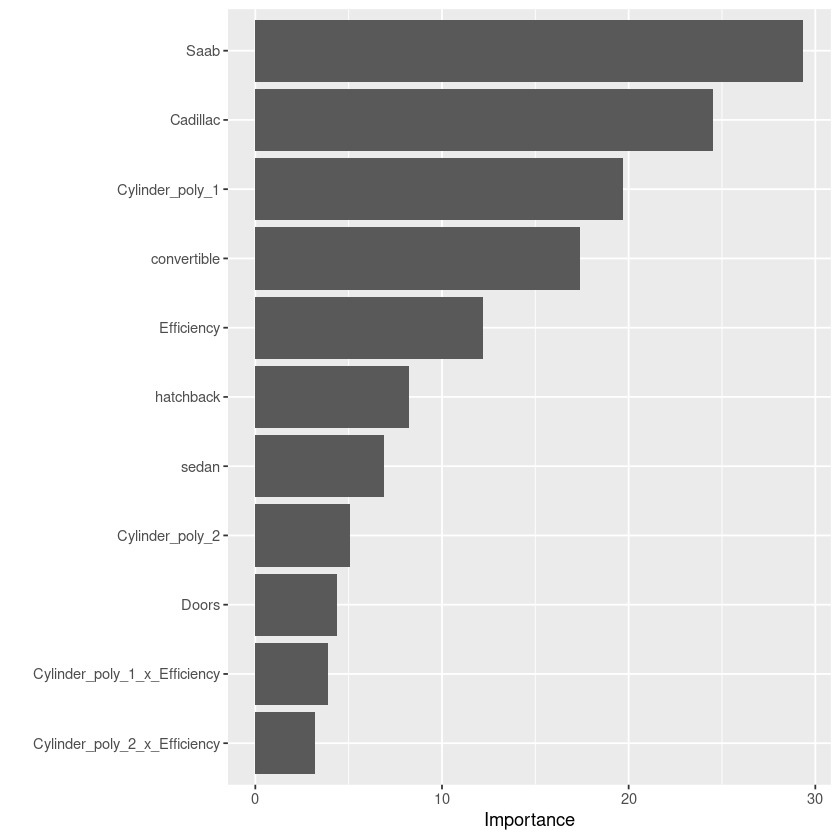

In [25]:
# Explore variable importance and consider eliminating some features. The code above shows the final iteration

fit %>%
  	 extract_fit_parsnip() %>%
  	 vip(num_features = 25L)



In [26]:
# Assess the model performance using the test dataset

final_performance <-
  	fit %>%
  	augment(new_data = test) %>%
  	metrics(truth = Price, estimate = .pred) %>%
	select(.estimate) %>%
	pull()



In [27]:
# Print vector with the final performance metrics

final_performance

[1]    0.9163532 2658.8698189